In [1]:
import csv
import torch
import torch.nn as nn
import numpy as np
import random                                                                  
import matplotlib.pyplot as plt
torch.backends.cudnn.deterministic=True
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import math
from torch.autograd import grad
from Libraries import robotarm as ra
from Libraries import ICNN_net as net
from Libraries import ICNN_plot as pl
from Libraries import ICNN_optim_custom_penalty_dd as opt
dtype = torch.float
device_c = torch.device("cpu")
device = torch.device("cuda:0")

In [2]:
#robot initialize
date = '0319_setting1'
l1 = 0.3 
l2 = 0.2
m1 = 3
m2 = 2
robot = ra.robotarm(l1,l2,m1,m2,device)
xinit = torch.tensor([[-2],[2]],dtype=dtype)
#xinit = torch.tensor([[0],[3]],dtype=dtype)
xfinal = torch.tensor([[3],[3]],dtype=dtype)
#xinit = torch.tensor([[-3],[0]],dtype=dtype)
#xfinal = torch.tensor([[3],[2.5]],dtype=dtype)
T = 3
delta = 0.6
num_timesteps = 100
#setting number 4
xpoints = np.array([  1.0,0.6,0.5,0.6,1.0])
ypoints = np.array([  1.5,1.7,1.9,2.3,2.6])
Vpoints = np.array([1.5,1.7,1.9,2.3,2.6])
#rmin,rmax,qmin,qmax,dt,qinit,qfinal,Xstable,xtraj,x_dot,qtraj,q_dot = robot.Initialize(xinit,xfinal,T,delta,num_timesteps)
rmin,rmax,qmin,qmax,dt,qinit,qfinal,Xstable,xtraj,qtraj,q_dot = robot.Initialize_spline(xpoints,ypoints,Vpoints, T, delta, num_timesteps)

#ICNN initialize
fhat_size = 500
V_size = 300
V_hidden_sizes = [V_size, V_size,V_size]
fhat_hidden_sizes = [fhat_size,fhat_size,fhat_size,fhat_size,fhat_size]
tol = 0.01
alpha = 0.01
#getting grid data (for the regularizer)
nq1 = 100 # grid number
nq2 = 100 
nq1_b = 10 # grid number
nq2_b = 10
penalty = 5000
penalty_boundary = 100000
alpha_kinematic = 0.01
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device,T) #qmin, qmax는 위에서 구함
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)
q_in_boundary,q_dot_boundary = optim_.get_boundary(nq1_b,nq2_b,qmin,qmax)
nq1_p = 100
nq2_p = 100
nx1 = 100
nx2 = 100
xmin = [-robot.l1-robot.l2, -robot.l2]
xmax = [robot.l1+robot.l2,robot.l1+robot.l2]

In [3]:
f = open(date+'_total_data.csv','w', newline='')
wr = csv.writer(f)
wr.writerow(['xpoints'])
wr.writerow(xpoints)
wr.writerow(['ypoints'])
wr.writerow(ypoints)
wr.writerow(['T = ',T])
wr.writerow(['delta = ',delta])
wr.writerow(['num_timesteps = ',num_timesteps])
f.close()

In [5]:
a,b,c,d,e = optim_.performance_metric(robot, q_in_reg, qtraj, q_dot,dt,q_in_boundary,q_dot_boundary, Xstable,alpha_kinematic)

#1 done
#2 done
#3 done
tensor(0.2217, device='cuda:0', grad_fn=<TraceBackward>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
..
tensor(0.2613, device='cuda:0', grad_fn=<TraceBackward>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
..
tensor(0.1850, device='cuda:0', grad_fn=<TraceBackward>)
tensor(9.1296e-05, device='cuda:0', grad_fn=<DivBackward0>)
..
tensor(0.2138, device='cuda:0', grad_fn=<TraceBackward>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
..
tensor(0.1975, device='cuda:0', grad_fn=<TraceBackward>)
tensor(9.7476e-05, device='cuda:0', grad_fn=<DivBackward0>)
..
tensor(0.1942, device='cuda:0', grad_fn=<TraceBackward>)
tensor(9.5823e-05, device='cuda:0', grad_fn=<DivBackward0>)
..
tensor(0.2448, device='cuda:0', grad_fn=<TraceBackward>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
..
tensor(0.2220, device='cuda:0', grad_fn=<TraceBackward>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
..
tensor(0.2161, device='cuda:0', grad

In [5]:
a,b,c,d,e

(tensor(38.0545, device='cuda:0'),
 tensor(21.4300, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(0.2190),
 tensor(0.0087, device='cuda:0'),
 tensor(0.0152, device='cuda:0'))

In [6]:
print(a,b,c,d,e)

tensor(38.0545, device='cuda:0') tensor(21.4300, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.2190) tensor(0.0087, device='cuda:0') tensor(0.0152, device='cuda:0')


# Ploting trajectory

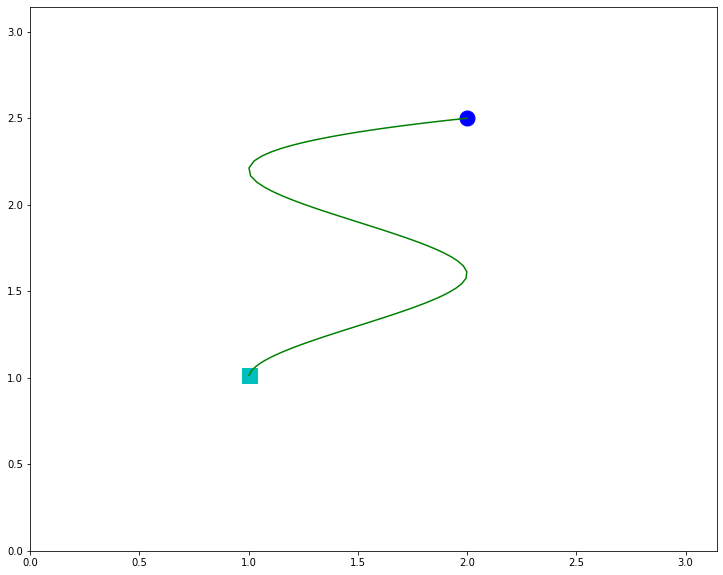

In [5]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_q_traj('qtraj.png')

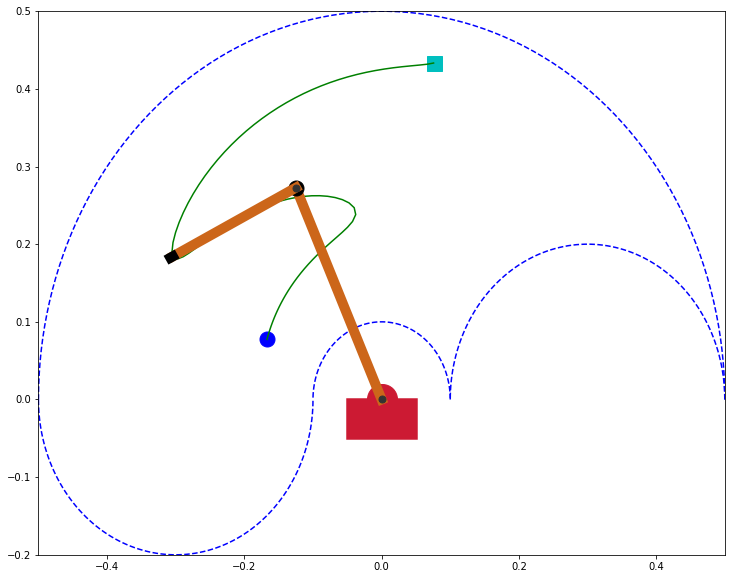

In [6]:
theta1 = xpoints[2]
theta2 = ypoints[2]
plt_.plot_robot_taskspace('robotplot.png', robot,theta1,theta2, traj=True)

# No Regularization

In [6]:
# initialize
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device,T)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [7]:
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000)

 epoch = 462, loss = 0.00044144166, loss_b = 0.0, loss_t = 0.00044144166                    .         .                                                                                                                                                                                                                                                                                                                                                                                                                                                              

KeyboardInterrupt: 

In [5]:
loss_traj_1, loss_boundary_1, loss_Euc_1, loss_kinematic_1, loss_kinetic_1 = optim_.performance_metric(robot, q_in_reg, qtraj, q_dot,dt,q_in_boundary,q_dot_boundary, Xstable,alpha_kinematic)
print(loss_traj_1, loss_boundary_1, loss_Euc_1, loss_kinematic_1, loss_kinetic_1)

#1 done
#2 done
#3 done
tensor(64.0736, device='cuda:0', grad_fn=<TraceBackward>)
tensor(270.1346, device='cuda:0', grad_fn=<TraceBackward>)
tensor(124.8520, device='cuda:0', grad_fn=<TraceBackward>)
tensor(165.3599, device='cuda:0', grad_fn=<TraceBackward>)
tensor(268.8344, device='cuda:0', grad_fn=<TraceBackward>)
tensor(59.0242, device='cuda:0', grad_fn=<TraceBackward>)
tensor(252.6307, device='cuda:0', grad_fn=<TraceBackward>)
tensor(119.0769, device='cuda:0', grad_fn=<TraceBackward>)
tensor(152.4027, device='cuda:0', grad_fn=<TraceBackward>)
tensor(254.7089, device='cuda:0', grad_fn=<TraceBackward>)
tensor(51.6719, device='cuda:0', grad_fn=<TraceBackward>)
tensor(235.0795, device='cuda:0', grad_fn=<TraceBackward>)
tensor(113.4938, device='cuda:0', grad_fn=<TraceBackward>)
tensor(140.4254, device='cuda:0', grad_fn=<TraceBackward>)
tensor(240.7970, device='cuda:0', grad_fn=<TraceBackward>)
tensor(47.0493, device='cuda:0', grad_fn=<TraceBackward>)
tensor(218.4960, device='cuda:0', gr

In [23]:
f = open(date+'_total_data.csv','a', newline='')
wr = csv.writer(f)
wr.writerow(['No Regularization'])
wr.writerow(['loss_traj_1', 'loss_boundary_1', 'loss_Euc_1', 'loss_kinematic_1', 'loss_kinetic_1'])
wr.writerow([loss_traj_1.data.to(device_c).numpy(), loss_boundary_1.data.to(device_c).numpy(), loss_Euc_1.data.to(device_c).numpy(), loss_kinematic_1.data.to(device_c).numpy(), loss_kinetic_1.data.to(device_c).numpy()])
f.close()

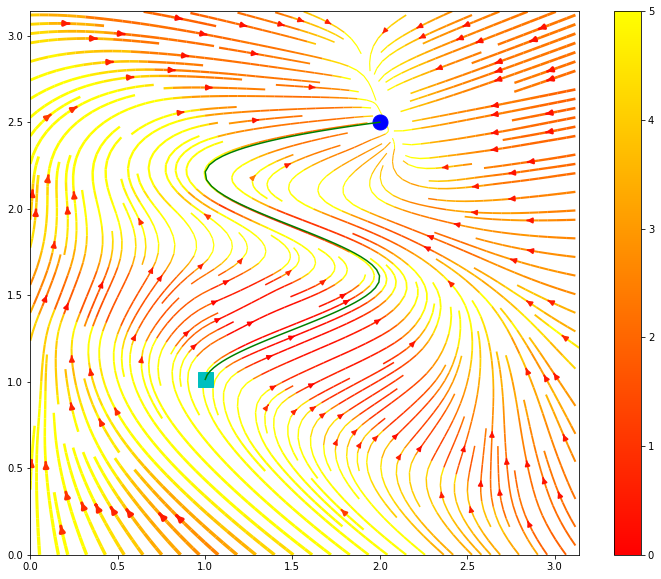

In [10]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_noreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

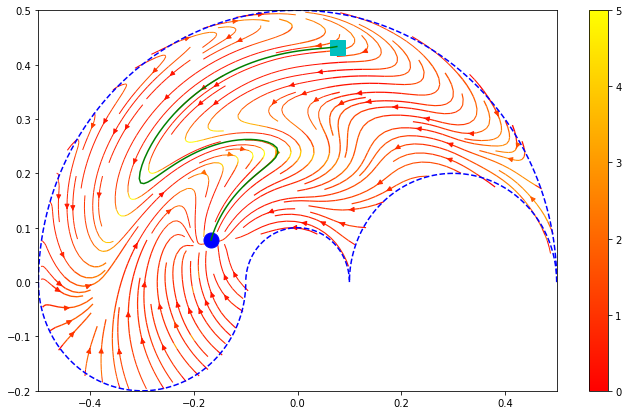

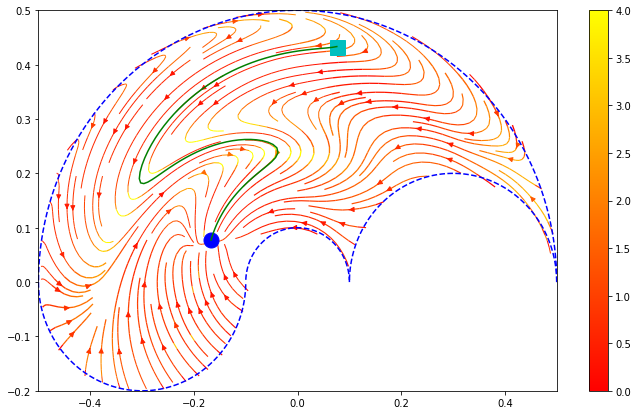

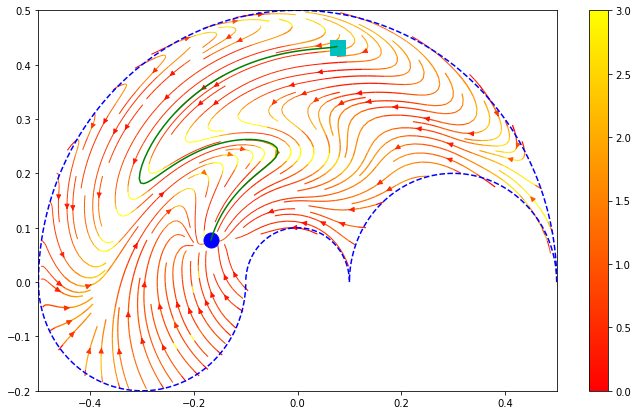

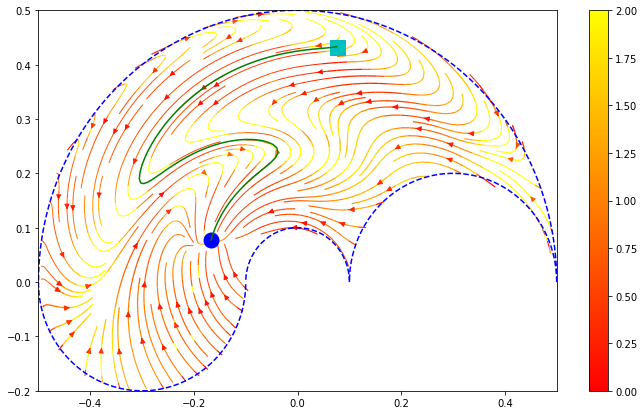

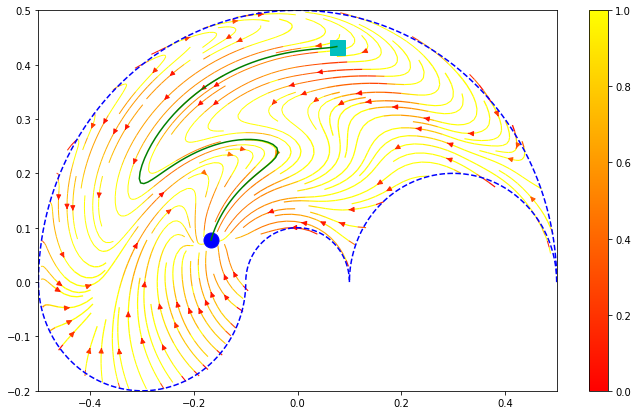

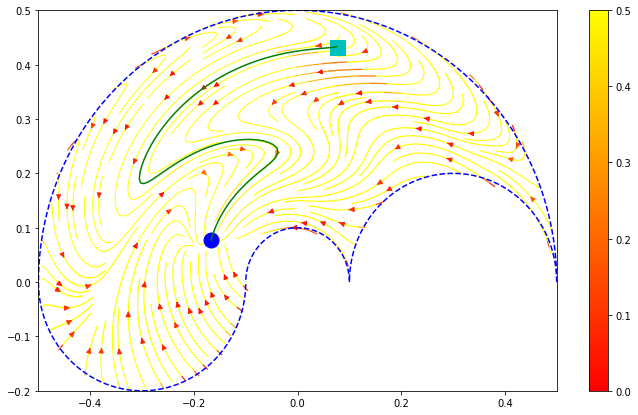

In [12]:
plt_.plot_f_taskspace('task_plot_noreg_'+date+'_5.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f_taskspace('task_plot_noreg_'+date+'_4.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=4)
plt_.plot_f_taskspace('task_plot_noreg_'+date+'_3.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=3)
plt_.plot_f_taskspace('task_plot_noreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)
plt_.plot_f_taskspace('task_plot_noreg_'+date+'_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=1)
plt_.plot_f_taskspace('task_plot_noreg_'+date+'_05.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=.5)

## weight norm decay

In [53]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device,T)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [54]:
#no regularization
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000)

 epoch = 1709, loss = 0.010143786, loss_b = 0.0, loss_t = 0.010143786                    . .      .  .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

KeyboardInterrupt: 

In [55]:
#####################################################################
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=10000,weight_decay = 1e-4)

 epoch = 5184, loss = 0.00015491516, loss_b = 9.522283e-05, loss_t = 0.0001549061                    ....                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

KeyboardInterrupt: 

In [56]:
loss_traj_2, loss_boundary_2, loss_Euc_2, loss_kinematic_2, loss_kinetic_2 = optim_.performance_metric(robot, q_in_reg, qtraj, q_dot,dt,q_in_boundary,q_dot_boundary, Xstable,alpha_kinematic)
print(loss_traj_2, loss_boundary_2, loss_Euc_2, loss_kinematic_2, loss_kinetic_2)

#1 done
#2 done
#3 done
#4 done
#5 done
tensor(0.0014, device='cuda:0') tensor(0., device='cuda:0', grad_fn=<MulBackward0>) tensor(1033.0100) tensor(8.8832, device='cuda:0') tensor(15.1460, device='cuda:0')


In [57]:
f = open(date+'_total_data.csv','a', newline='')
wr = csv.writer(f)
wr.writerow(['Weight Regularization'])
wr.writerow(['loss_traj_2', 'loss_boundary_2', 'loss_Euc_2', 'loss_kinematic_2', 'loss_kinetic_2'])
wr.writerow([loss_traj_2.data.to(device_c).numpy(), loss_boundary_2.data.to(device_c).numpy(), loss_Euc_2.data.to(device_c).numpy(), loss_kinematic_2.data.to(device_c).numpy(), loss_kinetic_2.data.to(device_c).numpy()])
f.close()

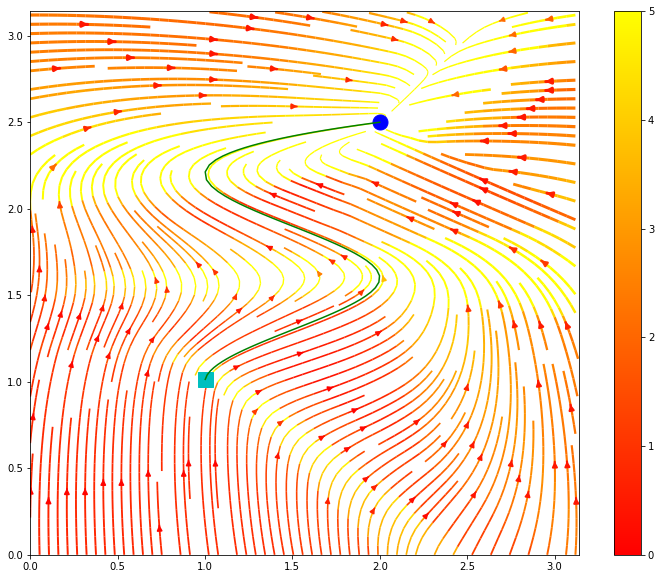

In [58]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_wreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

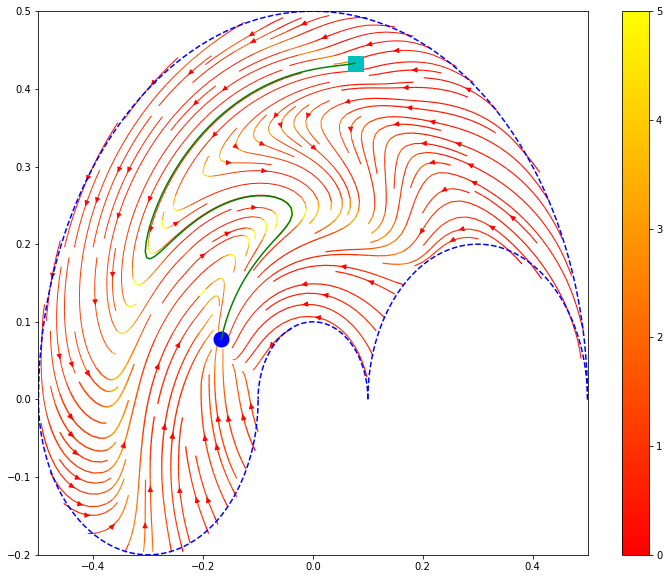

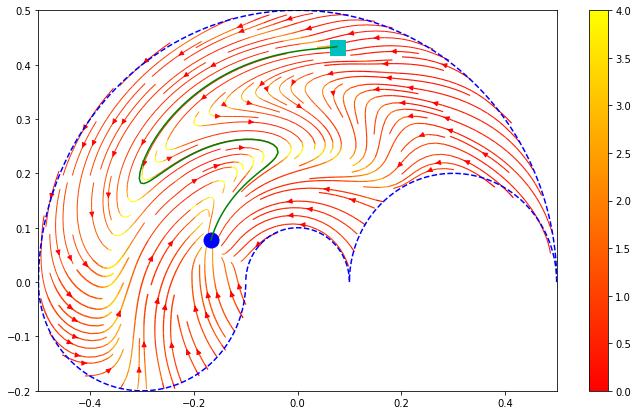

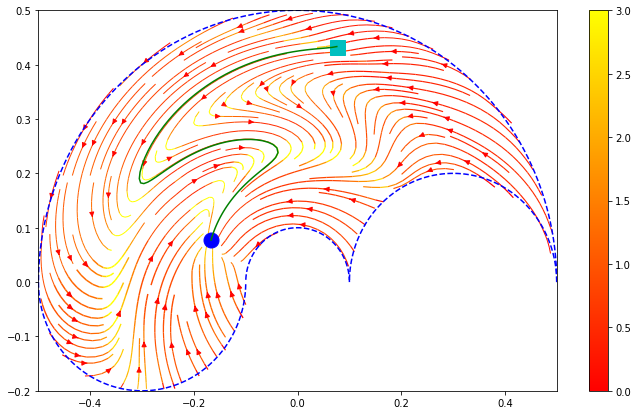

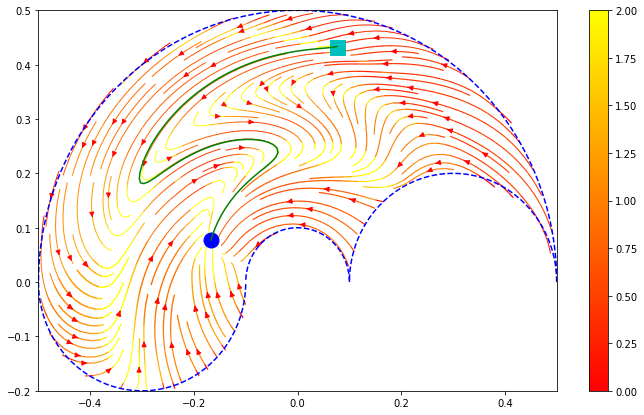

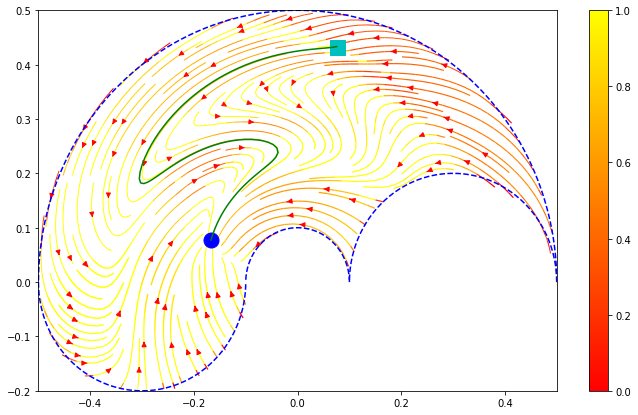

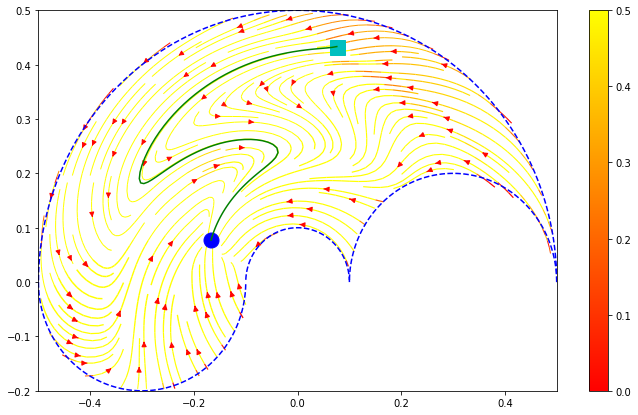

In [59]:
plt_.plot_f_taskspace('task_plot_wreg_'+date+'_5.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f_taskspace('task_plot_wreg_'+date+'_4.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=4)
plt_.plot_f_taskspace('task_plot_wreg_'+date+'_3.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=3)
plt_.plot_f_taskspace('task_plot_wreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)
plt_.plot_f_taskspace('task_plot_wreg_'+date+'_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=1)
plt_.plot_f_taskspace('task_plot_wreg_'+date+'_05.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=.5)

# Euclidean Regularization

In [22]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device,T)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [23]:
#no regularization
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000)

 epoch = 8758, loss = 0.0004010843, loss_b = 0.0, loss_t = 0.0004010843                    . ..  .......                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

KeyboardInterrupt: 

In [7]:
#####################################################################
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=10000,weight_decay = 1e-4)

 epoch = 3809, loss = 0.00017975969, loss_b = 0.0, loss_t = 0.00017975969                    .        ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

KeyboardInterrupt: 

In [8]:
#optimization for Euclidean regularizer
#mode 0: exp barrier, 1: relu squared
mode = 2
optim_.optim_Euc_reg(q_in_reg,qtraj ,q_dot,dt,q_in_boundary,q_dot_boundary,penalty,penalty_boundary, learning_rate = 1e-5,epoch=100, batch_size = 40,penalty_mode = mode)

 epoch = 1 i = 168, loss = 5779.243, total_loss = 5780.7715, loss_b = 0.0, loss_t = 0.00039517335, loss_reg = 12.881758, loss_reg_total =  14.340737           ...                                                                                                                                                                                                                                                                                                                                                                                                                            

KeyboardInterrupt: 

In [11]:
loss_traj_3, loss_boundary_3, loss_Euc_3, loss_kinematic_3, loss_kinetic_3 = optim_.performance_metric(robot, q_in_reg, qtraj, q_dot,dt,q_in_boundary,q_dot_boundary, Xstable,alpha_kinematic)
print(loss_traj_3, loss_boundary_3, loss_Euc_3, loss_kinematic_3, loss_kinetic_3)

#1 done
#2 done
#3 done
tensor(2.4625, device='cuda:0', grad_fn=<TraceBackward>)
tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
..
tensor(1.5554, device='cuda:0', grad_fn=<TraceBackward>)
tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
..
tensor(1.6460, device='cuda:0', grad_fn=<TraceBackward>)
tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
..
tensor(1.4687, device='cuda:0', grad_fn=<TraceBackward>)
tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>)
..
tensor(2.0491, device='cuda:0', grad_fn=<TraceBackward>)
tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
..
tensor(1.5548, device='cuda:0', grad_fn=<TraceBackward>)
tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
..
tensor(3.5067, device='cuda:0', grad_fn=<TraceBackward>)
tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
..
tensor(1.5229, device='cuda:0', grad_fn=<TraceBackward>)
tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
..
tensor(1.0554, device='cuda:0', grad_fn=<TraceBa

In [12]:
f = open(date+'_total_data.csv','a', newline='')
wr = csv.writer(f)
wr.writerow(['Euclidean Regularization'])
wr.writerow(['loss_traj_3', 'loss_boundary_3', 'loss_Euc_3', 'loss_kinematic_3', 'loss_kinetic_3'])
wr.writerow([loss_traj_3.data.to(device_c).numpy(), loss_boundary_3.data.to(device_c).numpy(), loss_Euc_3.data.to(device_c).numpy(), loss_kinematic_3.data.to(device_c).numpy(), loss_kinetic_3.data.to(device_c).numpy()])
f.close()

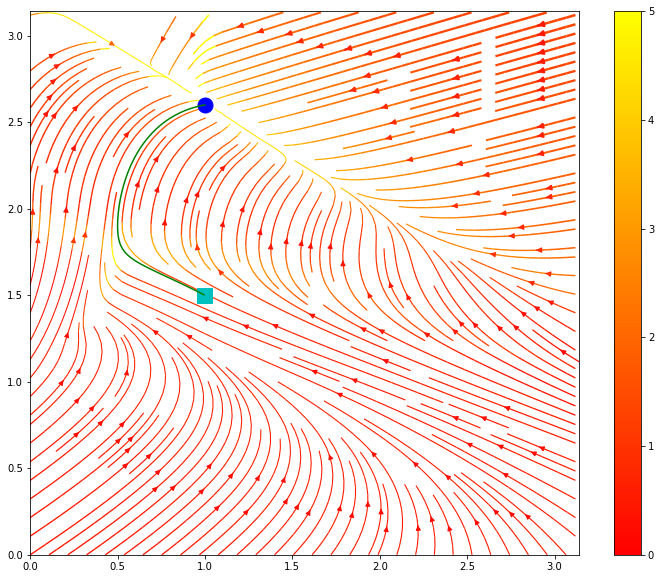

In [13]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_Eucreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

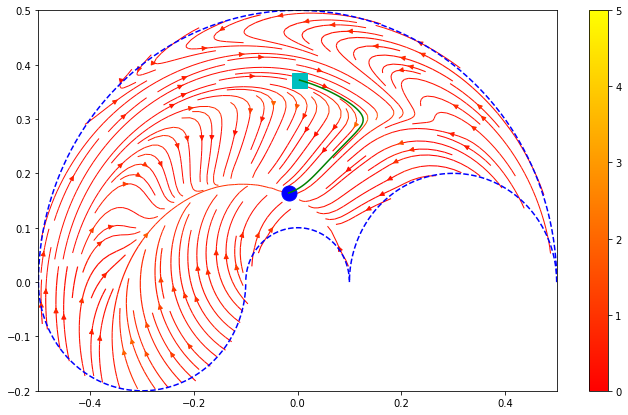

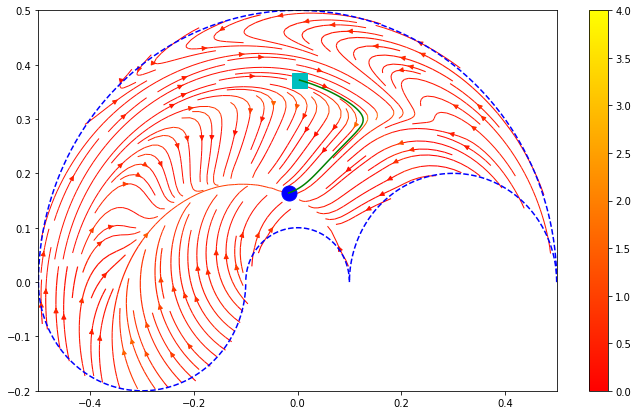

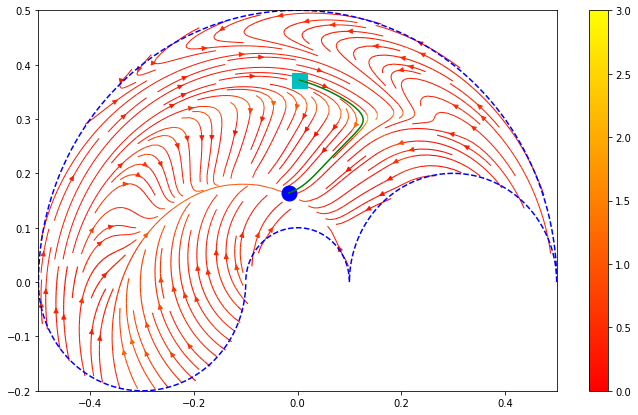

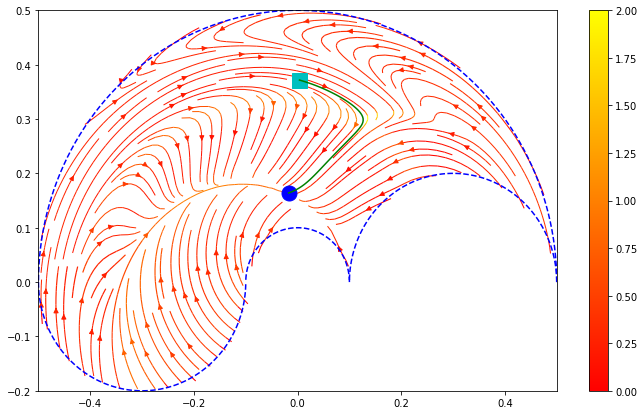

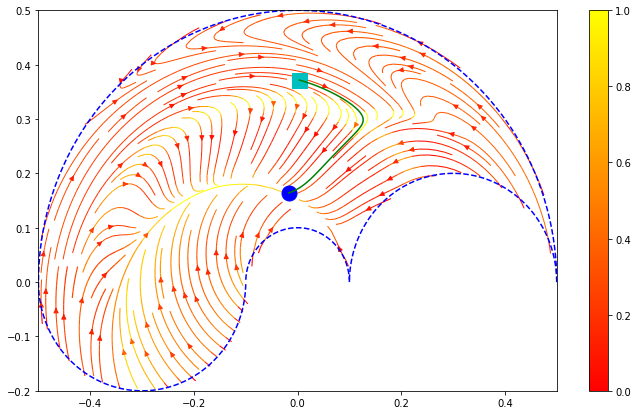

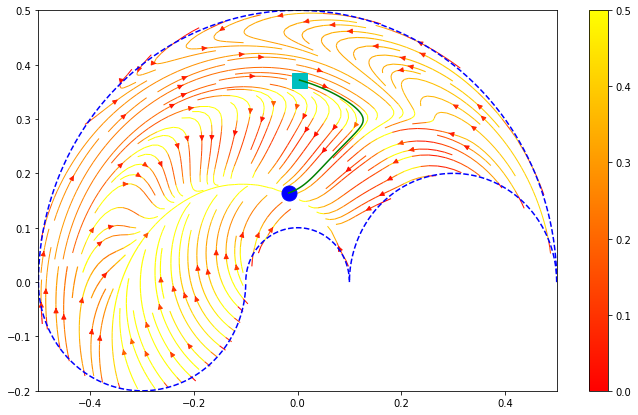

In [15]:
plt_.plot_f_taskspace('task_plot_Eucreg_'+date+'_5.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f_taskspace('task_plot_Eucreg_'+date+'_4.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=4)
plt_.plot_f_taskspace('task_plot_Eucreg_'+date+'_3.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=3)
plt_.plot_f_taskspace('task_plot_Eucreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)
plt_.plot_f_taskspace('task_plot_Eucreg_'+date+'_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=1)
plt_.plot_f_taskspace('task_plot_Eucreg_'+date+'_05.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=.5)

# Kinematic Regularization

In [4]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device,T)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [7]:
optim_.dA

tensor(0.0987)

In [19]:
#no regularization
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000)

 epoch = 258, loss = 0.005959592, loss_b = 0.0, loss_t = 0.005959592                    . .       .                                                                                                                                                                                                                                                         

KeyboardInterrupt: 

In [20]:
#####################################################################
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=1000,weight_decay = 1e-4)

 epoch = 801, loss = 0.00031313286, loss_b = 0.0, loss_t = 0.00031313286                    .         ..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

KeyboardInterrupt: 

In [4]:
#optimization for Euclidean regularizer
#mode 0: exp barrier, 1: relu squared

penalty = 10
penalty_boundary = 0
mode = 2
optim_.optim_Kinematic_reg(robot, q_in_reg,qtraj ,q_dot,dt,q_in_boundary,q_dot_boundary,penalty,penalty_boundary, Xstable,alpha_kinematic, learning_rate = 3e-5,epoch=150, batch_size = 40,penalty_mode = mode)

tensor(0.0516, device='cuda:0', grad_fn=<TraceBackward>)
 epoch = 0 i = 9, loss = nan, total_loss = nan, loss_b = 0.16585785, loss_t = 1.5028801, loss_reg = 0.0073963692, loss_reg_total =  0.003080778           ..      

KeyboardInterrupt: 

In [5]:
loss_traj_4, loss_boundary_4, loss_Euc_4, loss_kinematic_4, loss_kinetic_4 = optim_.performance_metric(robot, q_in_reg, qtraj, q_dot,dt,q_in_boundary,q_dot_boundary, Xstable,alpha_kinematic)
print(loss_traj_4, loss_boundary_4, loss_Euc_4, loss_kinematic_4, loss_kinetic_4)

#1 done
#2 done
#3 done
tensor(0.0769, device='cuda:0', grad_fn=<TraceBackward>)
tensor(3.7962e-05, device='cuda:0', grad_fn=<DivBackward0>)
..
tensor(0.0717, device='cuda:0', grad_fn=<TraceBackward>)
tensor(3.5382e-05, device='cuda:0', grad_fn=<DivBackward0>)
..
tensor(0.0811, device='cuda:0', grad_fn=<TraceBackward>)
tensor(4.0042e-05, device='cuda:0', grad_fn=<DivBackward0>)
..
tensor(0.1125, device='cuda:0', grad_fn=<TraceBackward>)
tensor(5.5503e-05, device='cuda:0', grad_fn=<DivBackward0>)
..
tensor(0.1025, device='cuda:0', grad_fn=<TraceBackward>)
tensor(5.0561e-05, device='cuda:0', grad_fn=<DivBackward0>)
..
tensor(0.0852, device='cuda:0', grad_fn=<TraceBackward>)
tensor(4.2067e-05, device='cuda:0', grad_fn=<DivBackward0>)
..
tensor(0.0764, device='cuda:0', grad_fn=<TraceBackward>)
tensor(3.7684e-05, device='cuda:0', grad_fn=<DivBackward0>)
..
tensor(0.1059, device='cuda:0', grad_fn=<TraceBackward>)
tensor(5.2274e-05, device='cuda:0', grad_fn=<DivBackward0>)
..
tensor(0.0781, d

KeyboardInterrupt: 

In [14]:
f = open(date+'_total_data.csv','a', newline='')
wr = csv.writer(f)
wr.writerow(['Kinematic Regularization'])
wr.writerow(['loss_traj_4', 'loss_boundary_4', 'loss_Euc_4', 'loss_kinematic_4', 'loss_kinetic_4'])
wr.writerow([loss_traj_4.data.to(device_c).numpy(), loss_boundary_4.data.to(device_c).numpy(), loss_Euc_4.data.to(device_c).numpy(), loss_kinematic_4.data.to(device_c).numpy(), loss_kinetic_4.data.to(device_c).numpy()])
f.close()

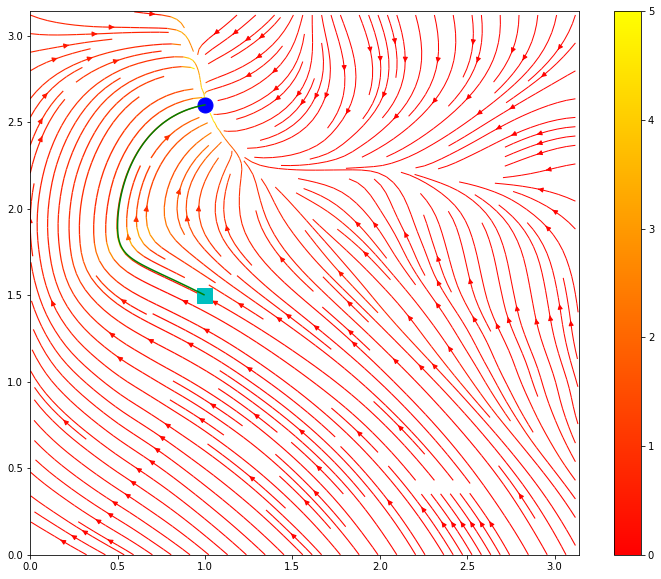

In [15]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_kinematicreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

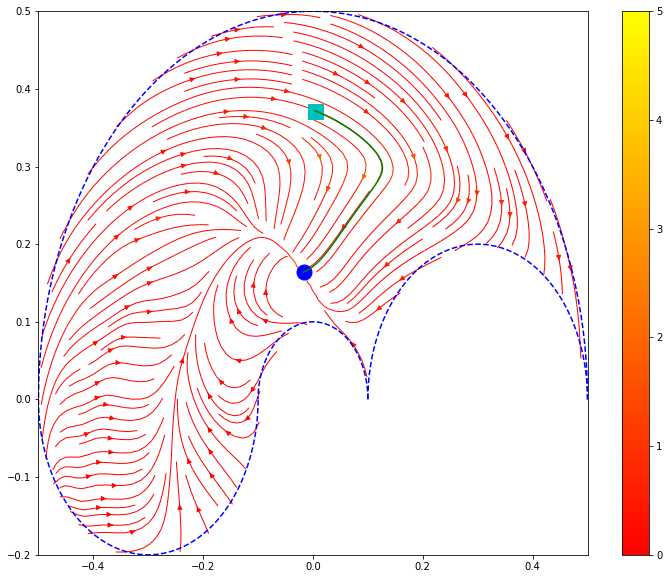

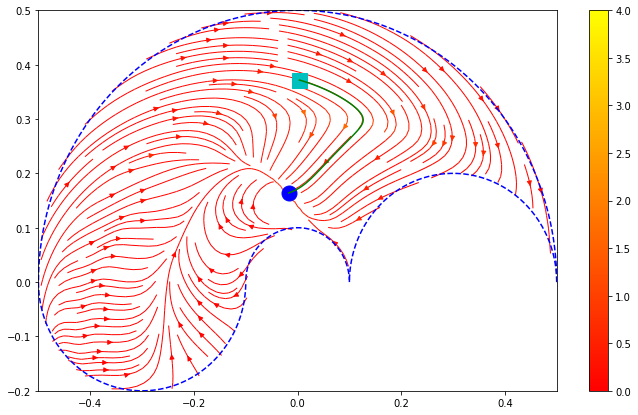

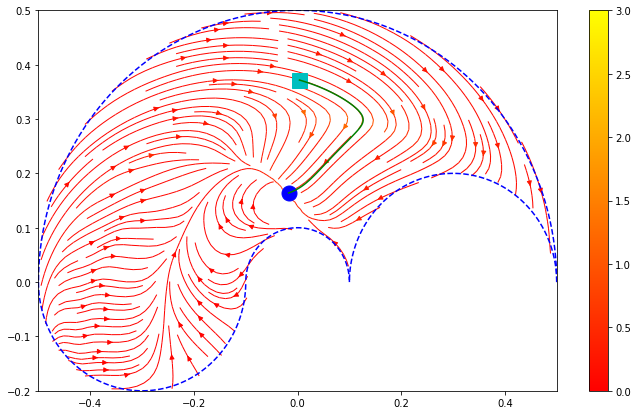

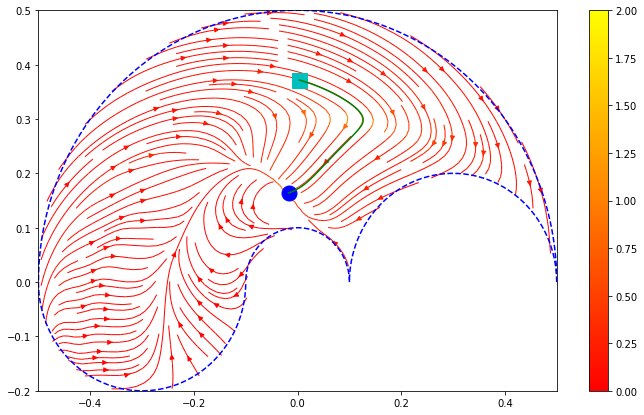

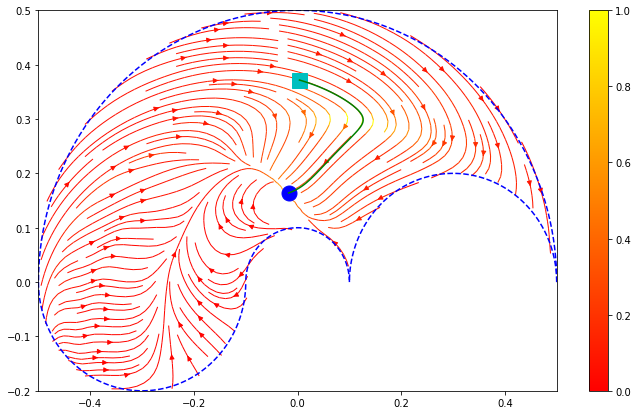

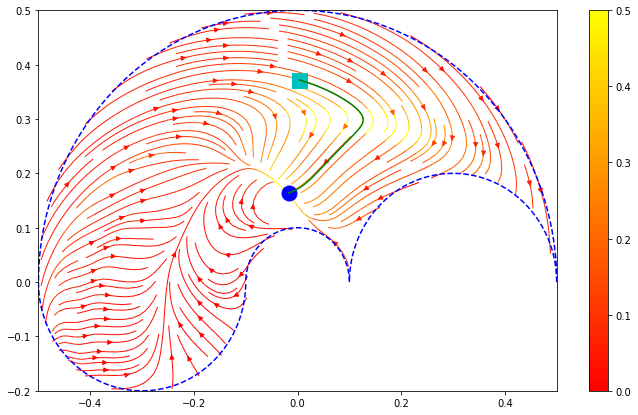

In [16]:
plt_.plot_f_taskspace('task_plot_kinematicreg_'+date+'_5.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f_taskspace('task_plot_kinematicreg_'+date+'_4.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=4)
plt_.plot_f_taskspace('task_plot_kinematicreg_'+date+'_3.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=3)
plt_.plot_f_taskspace('task_plot_kinematicreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)
plt_.plot_f_taskspace('task_plot_kinematicreg_'+date+'_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=1)
plt_.plot_f_taskspace('task_plot_kinematicreg_'+date+'_05.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=.5)

# Kinetic Regularization

In [24]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device,T)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [26]:
#no regularization
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000)

 epoch = 5357, loss = 0.00067470147, loss_b = 0.0, loss_t = 0.00067470147                    .  .. ..  ..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

KeyboardInterrupt: 

In [27]:
#####################################################################
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000,weight_decay = 1e-4)

 epoch = 1145, loss = 0.0002940032, loss_b = 0.0, loss_t = 0.0002940032                    . .     .....                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

KeyboardInterrupt: 

In [83]:
#optimization for Euclidean regularizer
#mode 0: exp barrier, 1: relu squared
optim_.optim_Kinetic_reg(robot, q_in_reg,qtraj ,q_dot,dt,q_in_boundary,q_dot_boundary,penalty,penalty_boundary, Xstable, learning_rate = 3e-5,epoch=500, batch_size = 40,penalty_mode = 2)

 epoch = 0 i = 6, loss = nan, total_loss = 13663.306, loss_b = 0.17491542, loss_t = 3.0869231, loss_reg = 0.7489049, loss_reg_total =  0.4526656           .         .      

KeyboardInterrupt: 

In [76]:
loss_traj_5, loss_boundary_5, loss_Euc_5, loss_kinematic_5, loss_kinetic_5 = optim_.performance_metric(robot, q_in_reg, qtraj, q_dot,dt,q_in_boundary,q_dot_boundary, Xstable,alpha_kinematic)
print(loss_traj_5, loss_boundary_5, loss_Euc_5, loss_kinematic_5, loss_kinetic_5)

#1 done
#2 done
#3 done
#4 done
#5 done
tensor(0.0003, device='cuda:0') tensor(0., device='cuda:0', grad_fn=<MulBackward0>) tensor(38612.5742) tensor(134.7602, device='cuda:0') tensor(282.3225, device='cuda:0')


In [77]:
f = open(date+'_total_data.csv','a', newline='')
wr = csv.writer(f)
wr.writerow(['Kinetic Regularization'])
wr.writerow(['loss_traj_5', 'loss_boundary_5', 'loss_Euc_5', 'loss_kinematic_5', 'loss_kinetic_5'])
wr.writerow([loss_traj_5.data.to(device_c).numpy(), loss_boundary_5.data.to(device_c).numpy(), loss_Euc_5.data.to(device_c).numpy(), loss_kinematic_5.data.to(device_c).numpy(), loss_kinetic_5.data.to(device_c).numpy()])
f.close()

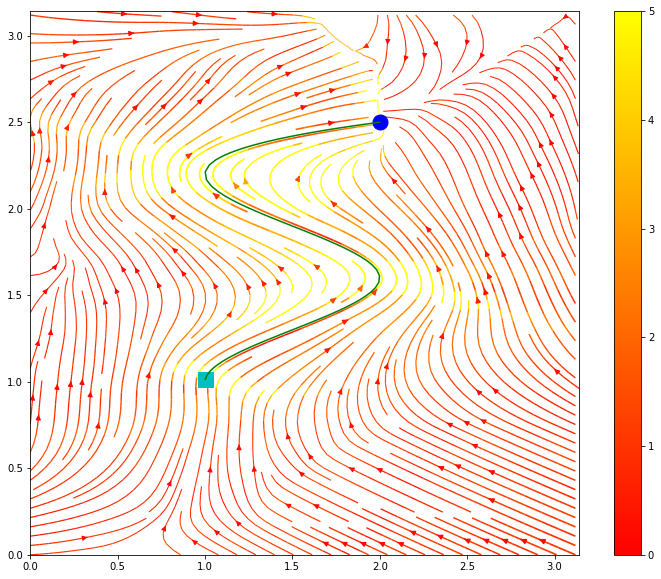

In [78]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_kineticreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

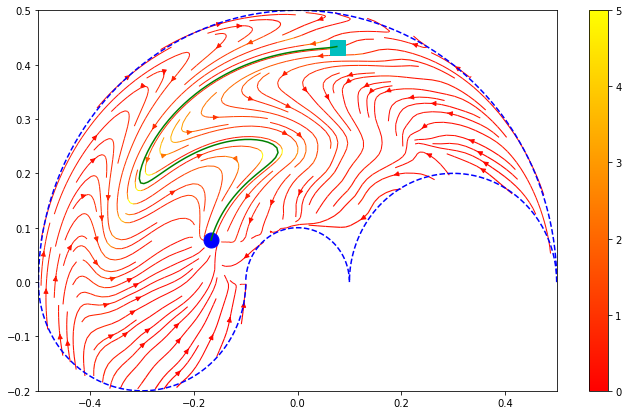

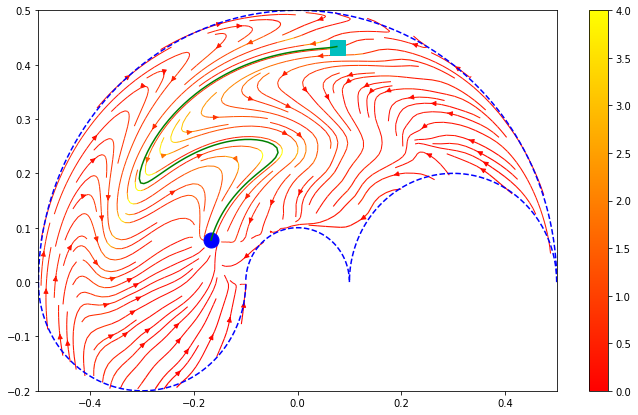

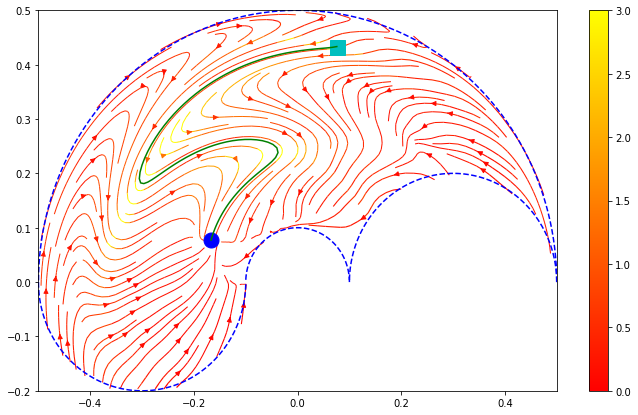

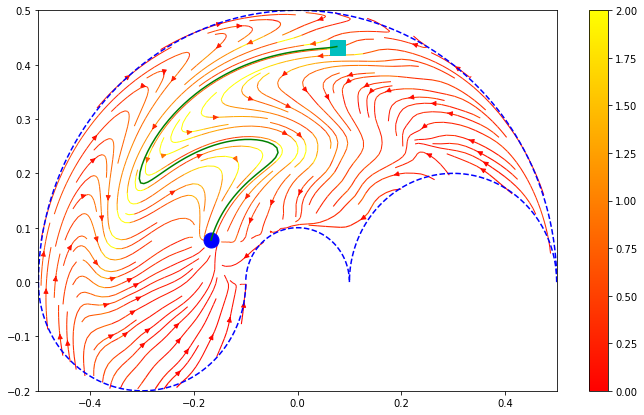

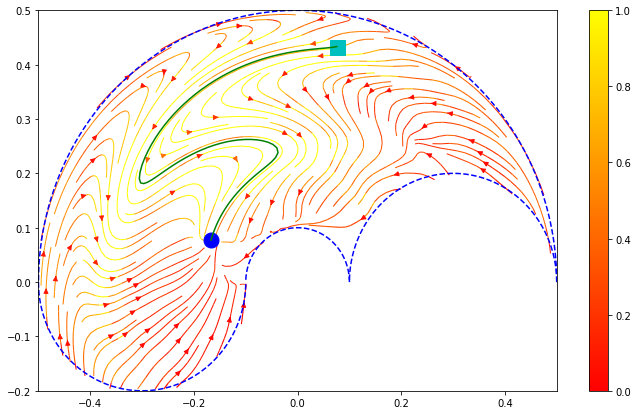

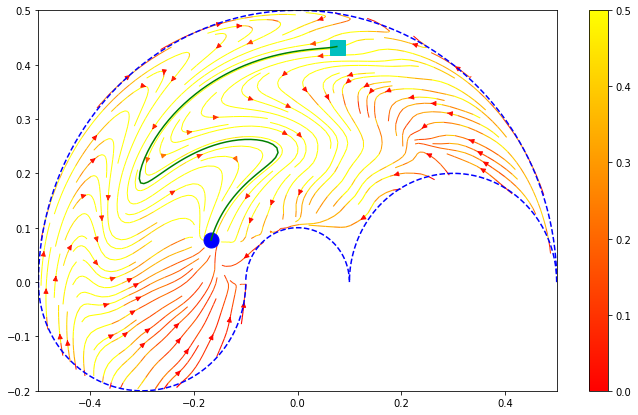

In [80]:
plt_.plot_f_taskspace('task_plot_kineticreg_'+date+'_5.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f_taskspace('task_plot_kineticreg_'+date+'_4.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=4)
plt_.plot_f_taskspace('task_plot_kineticreg_'+date+'_3.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=3)
plt_.plot_f_taskspace('task_plot_kineticreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)
plt_.plot_f_taskspace('task_plot_kineticreg_'+date+'_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=1)
plt_.plot_f_taskspace('task_plot_kineticreg_'+date+'_05.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=.5)

In [51]:
nq1_p = 100
nq2_p = 100
nx1 = 100
nx2 = 100
xmin = [-robot.l1-robot.l2, -robot.l2]
xmax = [robot.l1+robot.l2,robot.l1+robot.l2]
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)

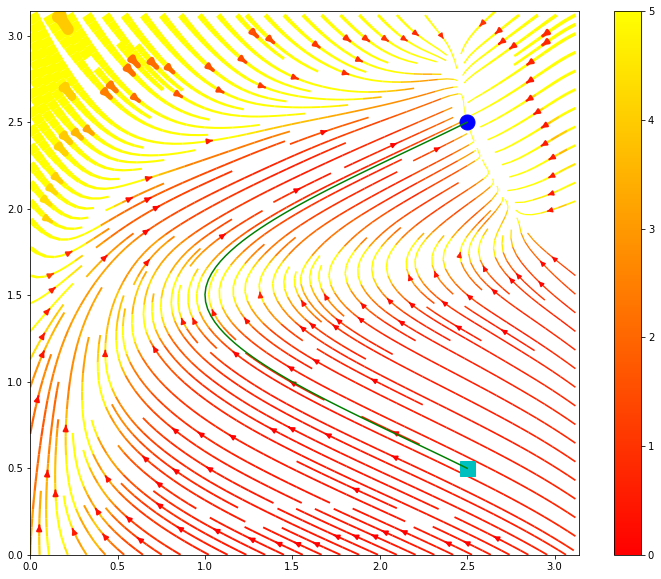

In [54]:
plt_.plot_f('fplot_noreg_0306_1.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

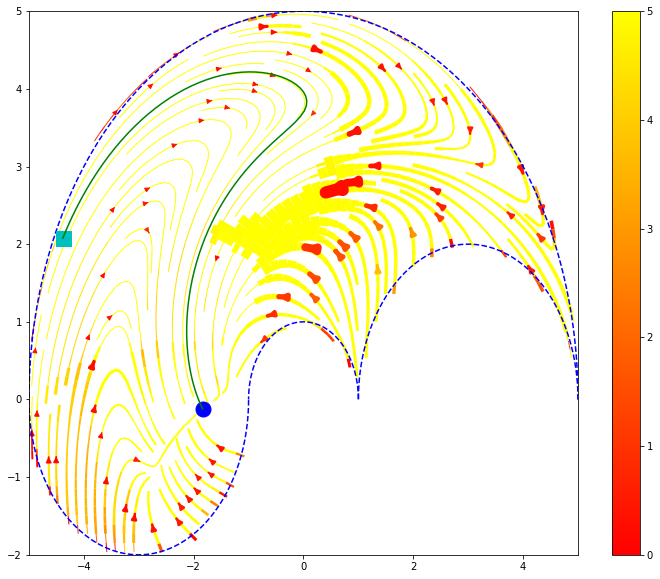

In [55]:
plt_.plot_f_taskspace('task_plot_0306_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)

In [ ]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device)

In [11]:
plt_.plot_V('t.png',3)

AttributeError: 'ICNN_net' object has no attribute 'fh_forward'